In [5]:
import pandas as pd
import pickle as pkl
import os


def get_target_df(ann_folder):
    rows = {}
    for filename in os.listdir(ann_folder):
        with open(os.path.join(ann_folder, filename), 'rb') as f:
            d = pkl.load(f)
            instance_data = next(iter(d.values()))
            anns = instance_data['diagnosis_anns']
            anns = {(k, question): v2 for k, v in anns.items() for question, v2 in v.items()}
            del instance_data['diagnosis_anns']
            instance_data.update(anns)
            rows.update(d)
    return pd.DataFrame(rows).transpose().sort_index()

from collections import defaultdict
def get_full_target_df(ann_dirs):
    dfs = defaultdict(lambda : pd.DataFrame([]))
    for ann_dir in ann_dirs:
        for split in os.listdir(ann_dir):
            for annotator in os.listdir(os.path.join(ann_dir, split)):
                df = get_target_df(os.path.join(ann_dir, split, annotator))
                df['annotator'] = [annotator] * len(df)
                dfs[split] = pd.concat([dfs[split], df])
    return dict(dfs)

In [6]:
dfs = get_full_target_df([
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_9-7-23/target_annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_9-29-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-3-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-9-23/target_annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-14-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-16-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-17-23/target_annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-20-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-21-23/target_annotations',
    ])
df = dfs['val2']
df

,instance_idx,split,"(pneumonia, is_confident_diagnosis)","(pneumonia, could_be_identified_earlier)","(cancer, is_confident_diagnosis)","(cancer, could_be_identified_earlier)","(pulmonary edema, is_confident_diagnosis)","(pulmonary edema, could_be_identified_earlier)",annotator,"(pulmonary edema, report_idx)","(pneumonia, report_idx)","(cancer, report_idx)"
0,11,val2,No,NaN,NaN,NaN,NaN,NaN,Andrea_Young,NaN,NaN,NaN
1,12,val2,Yes,Yes,NaN,NaN,NaN,NaN,Andrea_Young,NaN,NaN,NaN
2,16,val2,NaN,NaN,Yes,Yes,NaN,NaN,Andrea_Young,NaN,NaN,NaN
3,17,val2,No,NaN,NaN,NaN,Yes,No,Andrea_Young,NaN,NaN,NaN
4,22,val2,Yes,Yes,Yes,Yes,NaN,NaN,Andrea_Young,NaN,NaN,NaN
5,22,val2,No,NaN,Yes,Yes,NaN,NaN,Andrea_Young,NaN,NaN,NaN
6,34,val2,No,NaN,NaN,NaN,Yes,No,Andrea_Young,NaN,NaN,NaN
7,35,val2,NaN,NaN,Yes,Yes,NaN,NaN,Andrea_Young,NaN,NaN,NaN
8,40,val2,NaN,NaN,NaN,NaN,Yes,No,Andrea_Young,NaN,NaN,NaN
0,49,val2,Yes,Yes,NaN,NaN,Yes,No,Andrea,35,57,NaN


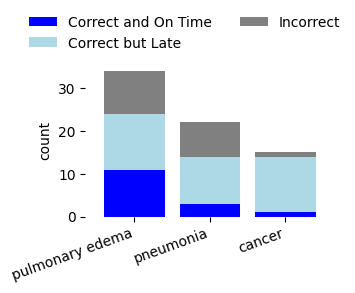

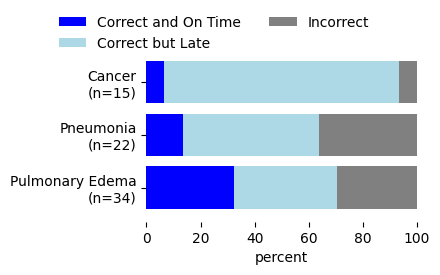

In [7]:
import seaborn as sns
from collections import Counter
import numpy as np
rows = []
for condition in ['pulmonary edema', 'pneumonia', 'cancer']:
    y = df[~df[(condition, 'is_confident_diagnosis')].isna()].apply(lambda r:
        'Incorrect' if r[(condition, 'is_confident_diagnosis')] == 'No' else \
        'Correct and On Time' if r[(condition, 'could_be_identified_earlier')] == 'No' else \
        'Correct but Late', axis=1)
    y = Counter(y)
    rows.append({
        'condition': condition,
    })
    rows[-1].update(y)
df_temp = pd.DataFrame(rows).set_index('condition')[['Correct and On Time', 'Correct but Late', 'Incorrect']]
counts = df_temp.sum(axis=1).to_dict()
# df_temp
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(3.5, 3.5))
chart = df_temp.plot(kind='bar', stacked=True, color=['blue', 'lightblue', 'grey'], width=.8, ax=axs)
chart.set_xlabel('')
chart.set_ylabel('count')
axis=chart.axis()
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.legend(
    ncols=2,
    loc="upper center",
    bbox_to_anchor=(0.4, 1.4), frameon=False)
axs.set_xticklabels(
    axs.get_xticklabels(),
    horizontalalignment='left',
    rotation=20,
    ha='right',
    # weight='bold',
    # fontsize=10,
)
fig.tight_layout()
fig, axs = plt.subplots(1, 1, figsize=(4.5, 3))
new_df_temp = {}
for x in df_temp.columns:
    new_df_temp[x] = df_temp.apply(lambda r: r[x] * 100 / sum([r[x2] for x2 in df_temp.columns]), axis=1)
df_temp = pd.DataFrame(new_df_temp).rename(index={k: f'{k.title()}\n(n={v})' for k, v in counts.items()})
chart = df_temp.plot(kind='barh', stacked=True, color=['blue', 'lightblue', 'grey'], width=.8, ax=axs)
chart.set_ylabel('')
chart.set_xlabel('percent')
chart.set_xlim(0, 100)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axis=chart.axis()
axs.legend(
    ncols=2,
    loc="upper center",
    bbox_to_anchor=(0.25, 1.26), frameon=False)
fig.tight_layout()
fig.savefig('figures/synthetic_labels_precision.pdf')
# mean_data = df_temp.groupby('model').agg({'max_usefulness': np.mean})
# sns.scatterplot(data=mean_data, x='model', y='max_usefulness', ax=chart, color='black', marker='s', linewidth=2)
# for i, row in mean_data.iterrows():
#     chart.annotate('%.1f' % row.max_usefulness, xy=(i, row.max_usefulness + .2), horizontalalignment='center', color='black', fontsize=14)
# chart.axis(axis)


In [9]:
instances_with_at_least_4_annotators = set([
    instance_idx for instance_idx in set(df.instance_idx) if len(set(df[df.instance_idx == instance_idx].annotator)) >= 4
])
instances_with_at_least_4_annotators

{49, 51, 53, 54, 58, 62}

In [14]:
df_for_agreement = df[df.instance_idx.isin(instances_with_at_least_4_annotators)]
annotators = list(set(df_for_agreement.annotator))
df_for_agreement_concat = []
for annotator in annotators:
    df_for_agreement_concat.append(
        df_for_agreement[df_for_agreement.annotator == annotator].drop(
            columns=['annotator']).set_index(['split', 'instance_idx']))
    df_for_agreement_concat[-1] = df_for_agreement_concat[-1].rename(
        columns={
            c: f'{c}_{annotator}'
            for c in df_for_agreement_concat[-1].columns
        })
df_for_agreement = pd.concat(df_for_agreement_concat, axis=1)
df_for_agreement

('pneumonia', 'is_confident_diagnosis')_Andrea   
split instance_idx                                                  
val2  49                                                      Yes  \
      51                                                      NaN   
      53                                                      NaN   
      54                                                      NaN   
      58                                                       No   
      62                                                      NaN   

                   ('pneumonia', 'could_be_identified_earlier')_Andrea   
split instance_idx                                                       
val2  49                                                          Yes   \
      51                                                          NaN    
      53                                                          NaN    
      54                                                          NaN    
      58                                                          NaN    
      62                                                          NaN    

                   ('cancer', 'is_confident_diagnosis')_Andrea   
split instance_idx                                               
val2  49                                                   NaN  \
      51                                                   NaN   
      53                                                   NaN   
      54                                                   Yes   
      58                                                   NaN   
      62                                                   NaN   

                   ('cancer', 'could_be_identified_earlier')_Andrea   
split instance_idx                                                    
val2  49                                                        NaN  \
      51                                                        NaN   
      53                                                        NaN   
      54                                                        Yes   
      58                                                        NaN   
      62                                                        NaN   

                   ('pulmonary edema', 'is_confident_diagnosis')_Andrea   
split instance_idx                                                        
val2  49                                                          Yes    \
      51                                                          Yes     
      53                                                          Yes     
      54                                                          NaN     
      58                                                           No     
      62                                                           No     

                   ('pulmonary edema', 'could_be_identified_earlier')_Andrea   
split instance_idx                                                             
val2  49                                                           No         \
      51                                                          Yes          
      53                                                           No          
      54                                                          NaN          
      58                                                          NaN          
      62                                                          NaN          

                   ('pulmonary edema', 'report_idx')_Andrea   
split instance_idx                                            
val2  49                                                 35  \
      51                                                  4   
      53                                                  3   
      54                                                NaN   
      58                                                  7   
      62                                                 31   

                   ('pneumon